In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Module scripts
from toss import compute_trajectory
from toss import compute_motion, setup_spin_axis, rotate_point
from toss import get_trajectory_fixed_step
from toss import FitnessFunctions
from toss import get_fitness
from toss import create_mesh
from toss import setup_parameters
from toss import plot_UDP_3D, plot_UDP_2D, fitness_over_generations, fitness_over_time, distance_deviation_over_time

# Core packages
from dotmap import DotMap
import numpy as np
from math import pi
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

Using numpy backend


In [3]:
args = setup_parameters()
x = np.genfromtxt('T23_champion_x.csv', delimiter=',')

# Separate each chromosome representing an induvidual spacecraft:
list_of_spacecrafts = np.array_split(x, args.problem.number_of_spacecrafts)

initial_conditions = [-135.13402075, -4089.53592604, 6050.17636635]*args.problem.number_of_spacecrafts
initial_conditions = np.array_split(initial_conditions, args.problem.number_of_spacecrafts)
for counter, spacecraft_info in enumerate(list_of_spacecrafts):
    list_of_spacecrafts[counter] = np.hstack((initial_conditions[counter], spacecraft_info))

# Resample and store trajectory for each spacecraft with a fixed time-step delta t
positions = None
velocities = None
timesteps = None
maneuver_times = None
maneuver_vectors = None

for counter, spacecraft in enumerate(list_of_spacecrafts):

    # Compute trajectory
    collision_detected, list_of_ode_objects, _ = compute_trajectory(spacecraft, args, compute_motion)
    
    # Resample trajectory for a fixed time-step delta t
    spacecraft_positions, spacecraft_velocities, spacecraft_timesteps = get_trajectory_fixed_step(args, list_of_ode_objects)

    # Manage maneuvers
    maneuvers = np.array_split(spacecraft[7:],args.problem.number_of_maneuvers)
    maneuver_t = np.zeros((len(maneuvers)))
    maneuver_v = np.zeros((3,len(maneuvers)))
    maneuver_p = np.zeros((3,len(maneuvers)))
    maneuver_unit_v = np.zeros((3,len(maneuvers)))
    for idx, maneuver in enumerate(maneuvers):
        # store time of maneuver and corresponding control vector
        maneuver_t[idx] = maneuver[0]
        maneuver_v[:,idx] = maneuver[1]*maneuver[2:]

        # Find position where maneuver was engaged as well as the maneuver unit vector
        maneuver_time_idx = (np.abs(np.asarray(spacecraft_timesteps) - maneuver[0])).argmin()
        maneuver_p[:,idx] = spacecraft_positions[:,maneuver_time_idx]
        maneuver_unit_v[:,idx] = maneuver_v[:,idx] / np.linalg.norm(maneuver_v[:,idx])


    # Store information
    if counter == 0:
        positions = spacecraft_positions
        velocities = spacecraft_velocities
        timesteps = spacecraft_timesteps
        maneuver_times = maneuver_t
        maneuver_vectors = maneuver_v
        maneuver_positions = maneuver_p
        maneuver_unit_vectors = maneuver_unit_v

    else:
        positions = np.hstack((positions, spacecraft_positions))
        velocities = np.hstack((velocities, spacecraft_velocities))
        maneuver_times = np.hstack((maneuver_times, maneuver_t))
        maneuver_vectors = np.hstack((maneuver_vectors, maneuver_v))
        maneuver_positions = np.hstack((maneuver_positions, maneuver_p))
        maneuver_unit_vectors = np.hstack((maneuver_unit_vectors, maneuver_unit_v))

In [6]:
# Compute fitness
fitness = get_fitness(FitnessFunctions.CoveredSpaceCloseDistancePenaltyFarDistancePenalty, args, positions, velocities, timesteps)
print("CoveredSpaceCloseDistancePenaltyFarDistancePenalty: ", fitness)

fitness = get_fitness(FitnessFunctions.CloseDistancePenalty, args, positions, velocities, timesteps)
print("CloseDistancePenalty: ", fitness)

fitness = get_fitness(FitnessFunctions.FarDistancePenalty, args, positions, velocities, timesteps)
print("FarDistancePenalty: ", fitness)

fitness = get_fitness(FitnessFunctions.CoveredSpace, args, positions, velocities, timesteps)
print("CoveredSpace: ", fitness)

CoveredSpaceCloseDistancePenaltyFarDistancePenalty:  0.10799028859227305
CloseDistancePenalty:  0
FarDistancePenalty:  0.22049545701316903
CoveredSpace:  0.11250516842089597


In [7]:
tot_dv_0 = 0
tot_dv_1 = 0
tot_dv_2 = 0
tot_dv_3 = 0


m_times = np.array_split(maneuver_times, 2)
m_vecs = np.array_split(maneuver_vectors, 2, axis=1)

for id, m_arr in enumerate(m_vecs):
    for i in range(0, len(m_times[0])):
        dv = np.linalg.norm(m_arr[:,i])

        if id == 0:
            tot_dv_0 = tot_dv_0 + dv
            print("Spacecraft " + str(id) + " dv " + str(i) + ": ", dv)
        
        if id == 1:
            tot_dv_1 = tot_dv_1 + dv
            print("Spacecraft " + str(id) + " dv " + str(i) + ": ", dv)
        
        if id == 2:
            tot_dv_2 = tot_dv_2 + dv
            print("Spacecraft " + str(id) + " dv " + str(i) + ": ", dv)
        
        if id == 3:
            tot_dv_3 = tot_dv_3 + dv
            print("Spacecraft " + str(id) + " dv " + str(i) + ": ", dv)

print("Spacecraft 0 tot dv ", tot_dv_0)
print("Spacecraft 1 tot dv ", tot_dv_1)
print("Spacecraft 2 tot dv ", tot_dv_2)
print("Spacecraft 3 tot dv ", tot_dv_3)


Spacecraft 0 dv 0:  1.787290386426682
Spacecraft 0 dv 1:  0.4607588574787158
Spacecraft 1 dv 0:  1.3729570199932244
Spacecraft 1 dv 1:  1.0298746535353878
Spacecraft 0 tot dv  2.248049243905398
Spacecraft 1 tot dv  2.4028316735286124
Spacecraft 2 tot dv  0
Spacecraft 3 tot dv  0


In [8]:
tot_dv = 0

for i in range(0, len(maneuver_times)):
    dv = np.linalg.norm(maneuver_vectors[:,i])
    print("dv " + str(i) + ": ", dv)
    tot_dv = tot_dv + dv
print("tot_dv: ", tot_dv)

dv 0:  1.787290386426682
dv 1:  0.4607588574787158
dv 2:  1.3729570199932244
dv 3:  1.0298746535353878
tot_dv:  4.65088091743401


In [9]:
position_list =  np.array_split(positions,args.problem.number_of_spacecrafts, axis=1)
maneuver_positions_list =  np.array_split(maneuver_positions,args.problem.number_of_spacecrafts, axis=1)
maneuver_unit_vectors_list =  np.array_split(maneuver_unit_vectors,args.problem.number_of_spacecrafts, axis=1)

# split arrays: 
#Spacecraft 1-2
positions_spaceraft_one_and_two = np.hstack((position_list[0], position_list[1]))
maneuver_positions_spaceraft_one_and_two = np.hstack((maneuver_positions_list[0], maneuver_positions_list[1]))
maneuver_unit_vectors_one_and_two = np.hstack((maneuver_unit_vectors_list[0], maneuver_unit_vectors_list[1]))

#Spacecraft 3-4
positions_spaceraft_three_and_four = np.hstack((position_list[2], position_list[3]))
maneuver_positions_spaceraft_three_and_four = np.hstack((maneuver_positions_list[2], maneuver_positions_list[3]))
maneuver_unit_vectors_three_and_four = np.hstack((maneuver_unit_vectors_list[2], maneuver_unit_vectors_list[3]))

args.problem.number_of_spacecrafts = 2 

(9149, 3)
(18294, 3)
3383.9457435491254


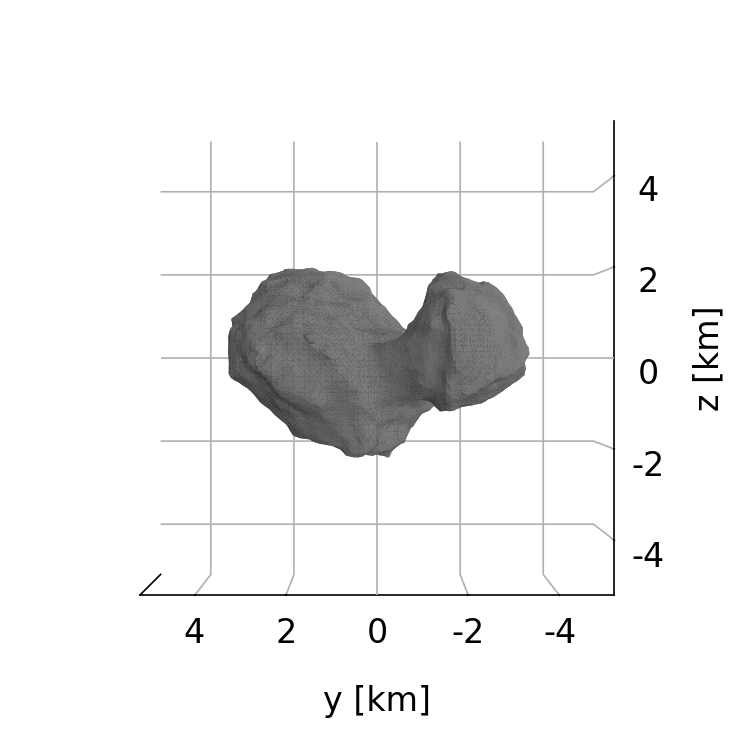

In [27]:
args.mesh.mesh_path = "3dmeshes/churyumov-gerasimenko.pk"

# Create mesh of body:
args.mesh.body, args.mesh.vertices, args.mesh.faces, args.mesh.largest_body_protuberant = create_mesh(args.mesh.mesh_path)
print(args.mesh.vertices.shape)
print(args.mesh.faces.shape)
print(args.mesh.largest_body_protuberant)

angle = [0,180]

plot_UDP_3D(args, positions, maneuver_positions, maneuver_unit_vectors, True, False, False, False, False, angle, None)

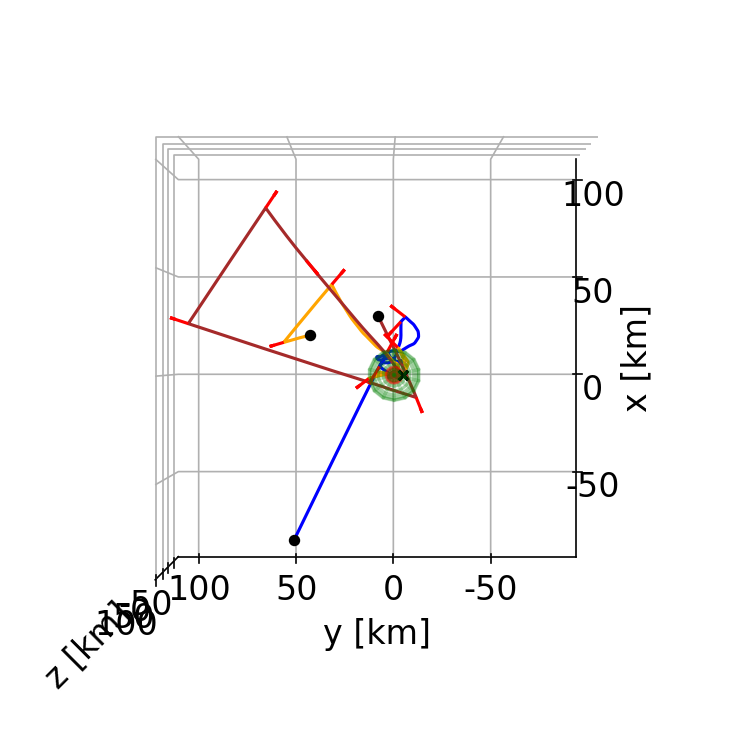

In [23]:
angle = [90,180]

plot_UDP_3D(args, positions, maneuver_positions, maneuver_unit_vectors, True, True, True, True, False, angle, None)

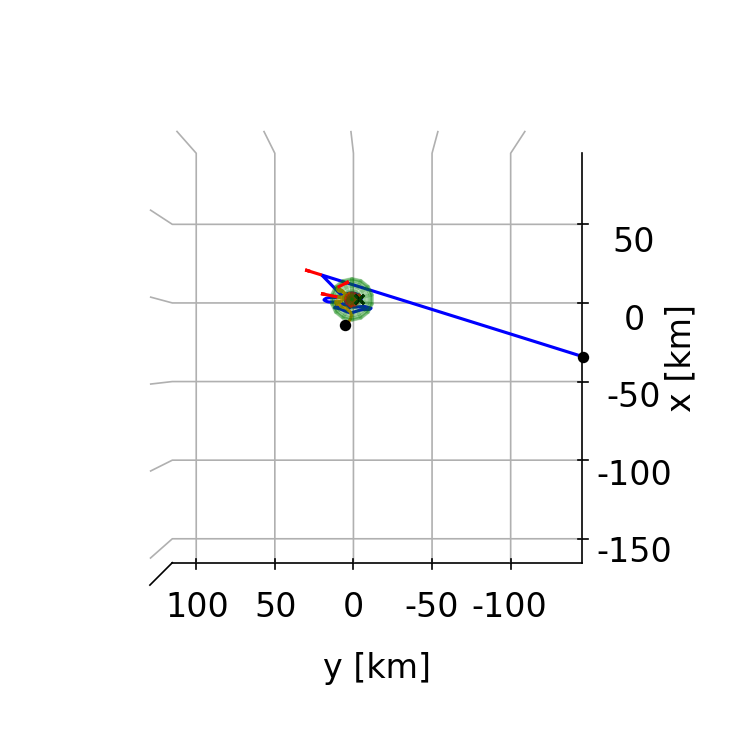

In [82]:
#angle = [0,180]
angle = [90,180]

plot_UDP_3D(args, positions_spaceraft_one_and_two, maneuver_positions_spaceraft_one_and_two, maneuver_unit_vectors_one_and_two, True, True, True, True, False, angle, None)

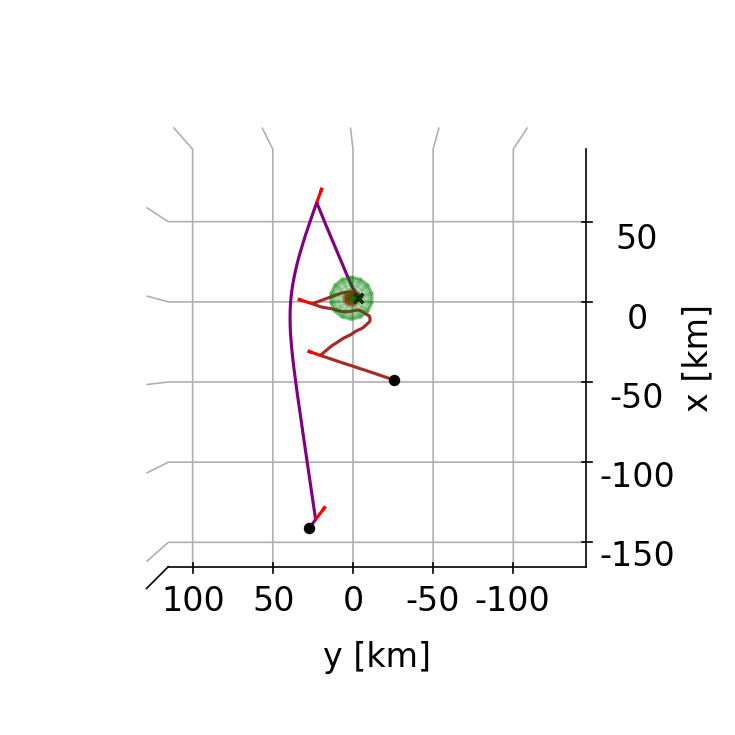

In [88]:
#angle = [0,180]
angle = [90,180]

plot_UDP_3D(args, positions_spaceraft_three_and_four, maneuver_positions_spaceraft_three_and_four, maneuver_unit_vectors_three_and_four, True, True, True, True, False, angle, None)

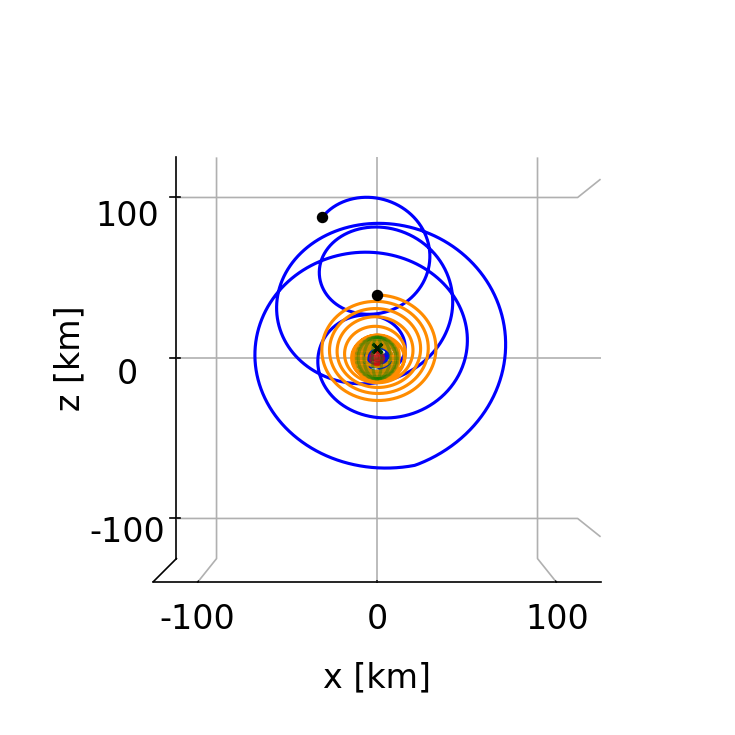

In [107]:
# Fixed body frame trajectory


#Spacecraft 1-2
# positions_spaceraft_one_and_two 
#Spacecraft 3-4
# positions_spaceraft_three_and_four

Array_of_positions = positions_spaceraft_one_and_two #positions_spaceraft_one_and_two #positions_spaceraft_three_and_four


# Single spacecraft
if args.problem.number_of_spacecrafts == 1:
    Array_of_positions = positions
    rotated_positions = np.zeros(Array_of_positions.shape)
    for col in range(0,len(Array_of_positions[0,:])):
        rotated_positions[:,col] = rotate_point(timesteps[col], Array_of_positions[:,col], args.body.spin_axis, args.body.spin_velocity)

# Multiple spacecraft
else:
    pos = np.array_split(Array_of_positions, args.problem.number_of_spacecrafts, axis=1)
    for i, spacecraft_pos in enumerate(pos):
        pos_rot = np.zeros(spacecraft_pos.shape)
        for col in range(0,len(spacecraft_pos[0,:])):
            pos_rot[:,col] = rotate_point(timesteps[col], spacecraft_pos[:,col], args.body.spin_axis, args.body.spin_velocity)
        if i == 0:
            rotated_positions = pos_rot
        else:
            rotated_positions = np.hstack((rotated_positions, pos_rot))


# Plot trajectory
plot_UDP_3D(args, rotated_positions, maneuver_positions, maneuver_unit_vectors, True, True, False, True, False, [0,270], None)

297


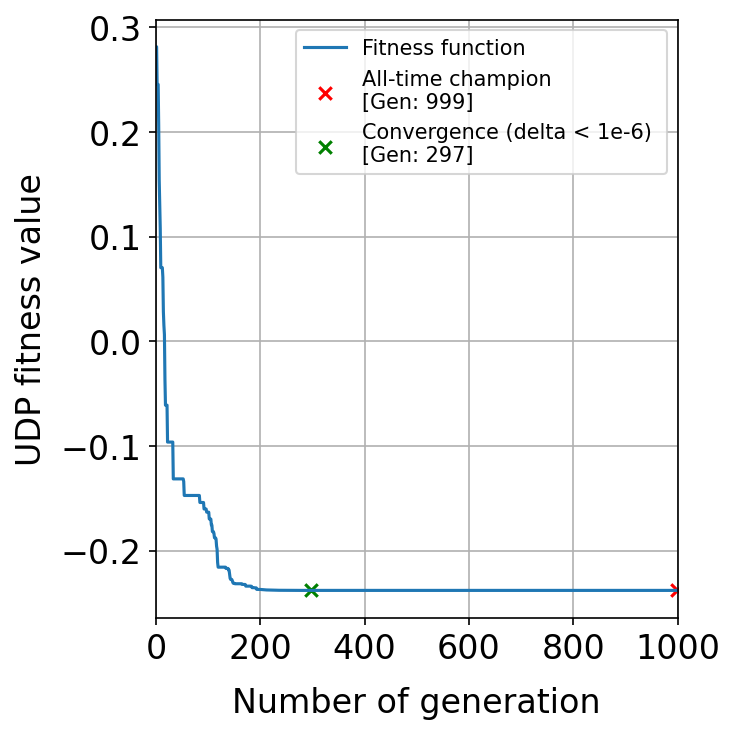

In [121]:
# Plot fitness over generations
fitness_list = np.genfromtxt('final_fitness_list.csv', delimiter=',')
n_generations = 1000
fitness_over_generations(fitness_list, n_generations)
# fitness_over_generations(np.flip(-1*fitness_list), n_generations) #if fitness has negative values

i:  864
i:  1728
i:  2592
i:  3456
i:  4320
i:  5184
i:  6048


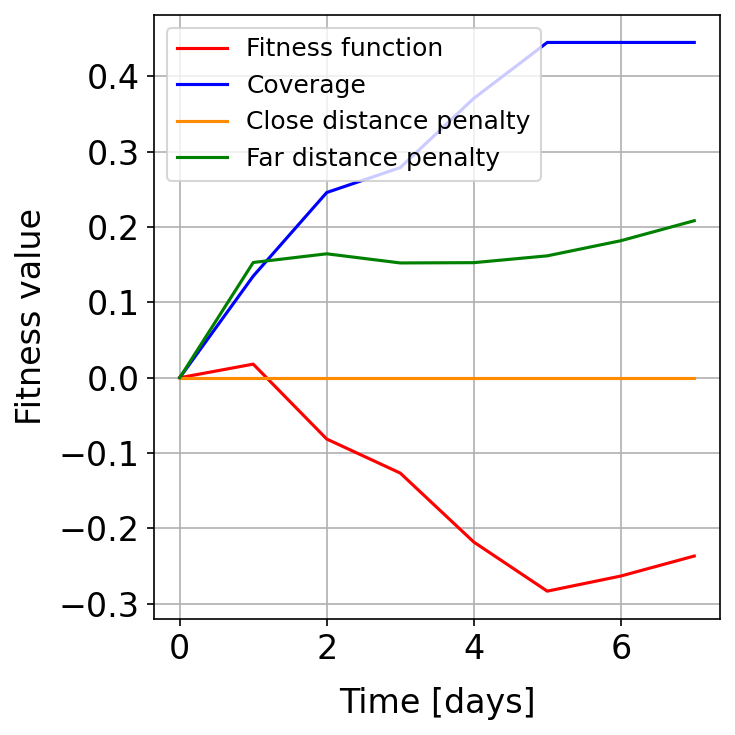

In [116]:
# Plot quality of signal over time
args.problem.number_of_spacecrafts = 4
#positions = np.array_split(positions, args.problem.number_of_spacecrafts)
sample_period = int(3600*24/args.problem.measurement_period) #1 day of values in one batch
coverage_list = [0] #zero coverage before mission.

# Compute penalty on initial position:
close_dist_penalty_list = []
far_dist_penalty_list = []
close_dist_penalty_list.append(get_fitness(FitnessFunctions.CloseDistancePenalty, args, positions[:,0], velocities[:,0], timesteps[0]))
far_dist_penalty_list.append(get_fitness(FitnessFunctions.FarDistancePenalty, args, positions[:,0], velocities[:,0], timesteps[0]))

fitness_list = [0]
#fitness_list.append(get_fitness(FitnessFunctions.CoveredSpaceCloseDistancePenaltyFarDistancePenalty, args, positions[:,0], velocities[:,0], timesteps[0]))


# Compute coverage and penatlies evolution over time

# Multiple spacecraft
if args.problem.number_of_spacecrafts > 1:
    positions_list = np.array_split(positions, args.problem.number_of_spacecrafts, axis=1)
    velocities_list = np.array_split(velocities, args.problem.number_of_spacecrafts, axis=1)

    for i in range(sample_period,len(positions_list[0][0,:])+sample_period, sample_period):   
        print("i: ", i)
        tstep = timesteps[:i]
        for spacecraft_idx in range(0, len(positions_list)):
            if spacecraft_idx == 0:
                pos = positions_list[spacecraft_idx][:, :i]
                vel = velocities_list[spacecraft_idx][:, :i]
            else:
                pos = np.hstack((pos,positions_list[spacecraft_idx][:, :i]))
                vel = np.hstack((vel,velocities_list[spacecraft_idx][:, :i]))
        
        coverage_list.append(get_fitness(FitnessFunctions.CoveredSpace, args, pos, vel, tstep))
        close_dist_penalty_list.append(get_fitness(FitnessFunctions.CloseDistancePenalty, args, pos, vel, tstep))
        far_dist_penalty_list.append(get_fitness(FitnessFunctions.FarDistancePenalty, args, pos, vel, tstep))
        fitness_list.append(get_fitness(FitnessFunctions.CoveredSpaceCloseDistancePenaltyFarDistancePenalty, args, pos, vel, tstep))


# Single spacecraft
else:
    for i in range(sample_period,len(positions[0,:])+ sample_period, sample_period):
        pos = positions[:, :i]
        vel = velocities[:, :i]
        tstep = timesteps[:i]
        
        coverage_list.append(get_fitness(FitnessFunctions.CoveredSpace, args, pos, vel, tstep))
        close_dist_penalty_list.append(get_fitness(FitnessFunctions.CloseDistancePenalty, args, pos, vel, timesteps))
        far_dist_penalty_list.append(get_fitness(FitnessFunctions.FarDistancePenalty, args, pos, vel, tstep))
        fitness_list.append(get_fitness(FitnessFunctions.CoveredSpaceCloseDistancePenaltyFarDistancePenalty, args, pos, vel, tstep))


# Generate new time axis
time_axis = np.arange(0, int((args.problem.final_time/3600)/24)+1, 1) #+1 to also include day zero with zero coverage.

fitness_over_time(fitness_list, coverage_list, close_dist_penalty_list, far_dist_penalty_list, time_axis)


(2000,)
(3, 2000)


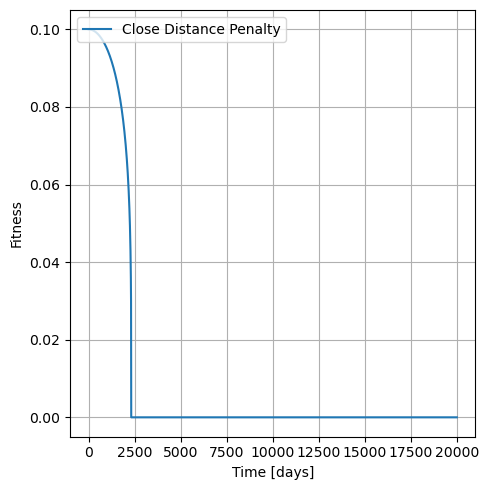

In [21]:
valx = np.arange(0,20000, 10)
valy = np.arange(0,20000, 10)
valz = np.arange(0,20000, 10)

val_arr = np.vstack((valx, valy, valz))
print(valx.shape)
print(val_arr.shape)
fitness_vals = []
for i in range(0, val_arr.shape[1]):
    fitness_vals.append(get_fitness(FitnessFunctions.CloseDistancePenalty, args, val_arr[:,i], [], valx))


# Plot fitness over generations
figure, ax = plt.subplots(figsize=(5, 5))
ax.plot(valx, fitness_vals, label='Close Distance Penalty')

# Adjust plot settings
#ax.set_xlim((0, timelist))
ax.grid('major')
#ax.set_title('Coverage evolution', fontweight='bold')
ax.set_xlabel('Time [days]')
ax.set_ylabel('Fitness')
ax.legend(loc='upper left')
#ax.set_yscale('log')
plt.tight_layout()
plt.show()



(2000,)
(3, 2000)


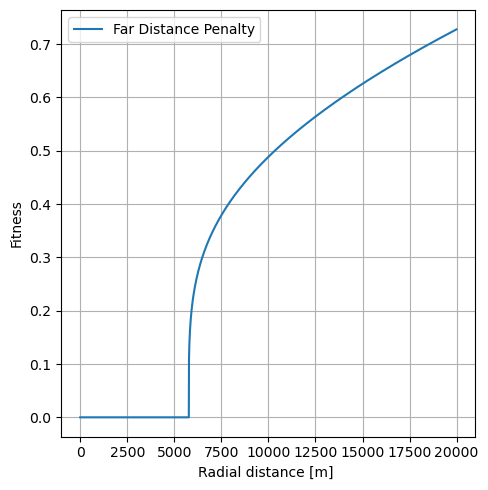

In [17]:
valx = np.arange(0,20000, 10)
valy = np.arange(0,20000, 10)
valz = np.arange(0,20000, 10)

valr = (valx**2 + valy**2 + valz**2)**(1/2)

val_arr = np.vstack((valx, valy, valz))
print(valx.shape)
print(val_arr.shape)
fitness_vals = []
for i in range(1, val_arr.shape[1]+1):
    fitness_vals.append(get_fitness(FitnessFunctions.FarDistancePenalty, args, val_arr[:,0:i], [], valr))


# Plot fitness over generations
figure, ax = plt.subplots(figsize=(5, 5))
ax.plot(valx, fitness_vals, label='Far Distance Penalty')

# Adjust plot settings
#ax.set_xlim((0, timelist))
ax.grid('major')
#ax.set_title('Coverage evolution', fontweight='bold')
ax.set_xlabel('Radial distance [m] ')
ax.set_ylabel('Fitness')
ax.legend(loc='upper left')
#ax.set_yscale('log')
plt.tight_layout()
plt.show()

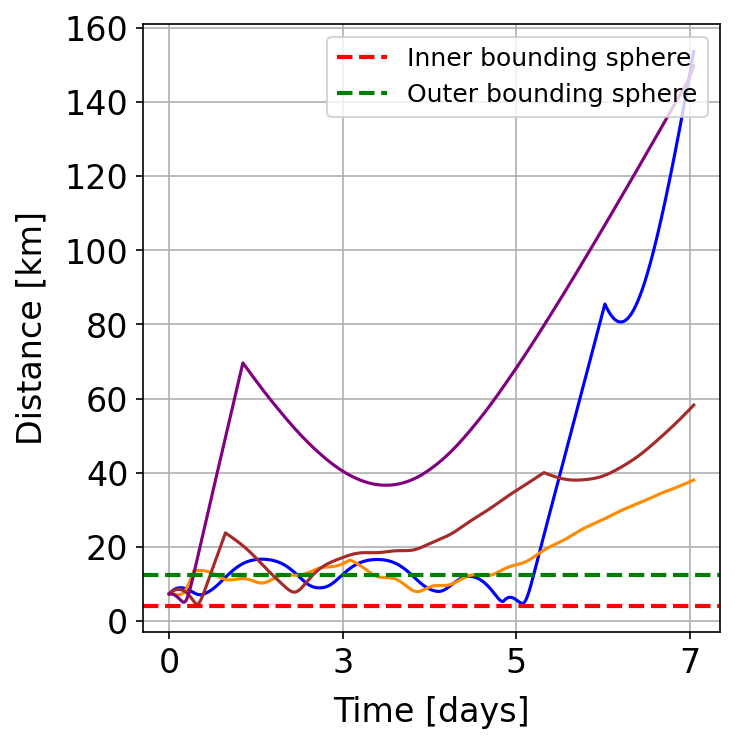

In [120]:
# Distance deviation over time
distance_deviation_over_time(args.problem.number_of_spacecrafts, args.problem.radius_inner_bounding_sphere, args.problem.radius_outer_bounding_sphere, positions, timesteps)